In [1]:
import seaborn as sns
from queries import*
from utilities import*

In [10]:
Directory = os.getcwd()
Directory_path = Directory + '/data/input'
files = os.listdir(Directory_path)
files[28:]

['DEEPMEL_1C1',
 'DEEPMEL_2L1',
 'DEEPMEL_1P1',
 'DEEPMEL_1X1',
 'DEEPMEL_2O1',
 'DEEPMEL_1U1',
 'DEEPMEL_2H1',
 'DEEPMEL_1X3',
 'DEEPMEL_1J2',
 'DEEPMEL_3D1',
 'DEEPMEL_1E1',
 'DEEPMEL_3J2',
 '.ipynb_checkpoints',
 'DEEPMEL_1W1',
 'DEEPMEL_1J1',
 'DEEPMEL_2V1',
 'DEEPMEL_2Y1',
 'DEEPMEL_1F1',
 'DEEPMEL_2G1',
 'DEEPMEL_2R1',
 'DEEPMEL_1M1',
 'DEEPMEL_2K1',
 'DEEPMEL_2Z1',
 'DEEPMEL_1V1',
 'DEEPMEL_3C1',
 'DEEPMEL_1X2',
 'DEEPMEL_2W1',
 'DEEPMEL_1O1',
 'DEEPMEL_2U2',
 'DEEPMEL_2Q1',
 'DEEPMEL_2E1',
 'DEEPMEL_2S1',
 'DEEPMEL_2D1',
 'DEEPMEL_2J1',
 'DEEPMEL_2B2',
 'DEEPMEL_2X1',
 'DEEPMEL_3H1',
 'axis_data_1C1.csv',
 'DEEPMEL_1N1']

In [ ]:
Directory = os.getcwd()
Directory_path = Directory + '/data/input'
files = os.listdir(Directory_path)
plot_Directory = Directory + '/plots'

for file in files[64:]:
    
    array = file.split('_')
    if len(array):
        condition = array[0]
        PATIENT_ID = array[1]
    else:
        condition == ''
        
    
    if condition == 'DEEPMEL':
        
        
        print('Treating patient' + PATIENT_ID)

        
        INPUT_PATH = './data/input/DEEPMEL_' + PATIENT_ID + '/'
        OUTPUT_PATH = './data/output/DEEPMEL_' + PATIENT_ID +'/'
        PLOT_PATH ='./plots/DEEPMEL_' + PATIENT_ID +'/'
        INPUT_FILE = 'DEEPMEL_'+ PATIENT_ID +'_cell_seg_data.csv'
        TABLE_NAME_BQ = 'DEEPMEL_'+ PATIENT_ID +'_cell_seg_data'
        
        if not(file in  os.listdir(plot_Directory)):
            path = plot_Directory +'/'+ file
            try:
                os.mkdir(path)
            except OSError:
                print ("Creation of the directory %s failed" % path)
            else:
                print ("Successfully created the directory %s " % path)
        
        cell_data = pd.read_csv(INPUT_PATH + INPUT_FILE)
        cell_data['phenotype'] = cell_data['phenotype'].apply(lambda x: get_phenotype(x))
        
        total_edges = pd.read_csv(OUTPUT_PATH+'graph_edges.csv')
        N = len(total_edges)
        r = int((N/1000)/2000)+1 
        q = [int(c) for c in np.linspace(0, N, r+2)]
        total_edges_border = pd.DataFrame({})
        print('Dividing to '+ str(len(q)) + ' parts, done')
        for index in range(len(q))[1:]:
            lower_bound = q[index-1]
            upper_bound = q[index]
            total_edges_part = total_edges[lower_bound:upper_bound].copy()
            total_edges_part['is_border'] = total_edges_part.apply((lambda x : 1 if ( x.tissue_category_1 != x.tissue_category_2) else  0), axis = 1)
            total_edges_border = pd.concat([total_edges_border,total_edges_part])

        total_edges = total_edges_border.copy()
        sns.displot(total_edges, x="distance", binwidth=3).savefig(PLOT_PATH+'hist_distances.png')
        
        print('Extracting neighberhood...')
        
        exact_border_df = total_edges[total_edges.is_border == 1].copy()
        ### Getting a list of cell_id  that are on the border
        border_cells = get_cells_from_edges(exact_border_df)
        #### Border dataframe
        border_df = pd.DataFrame({})
        border_df['cell_id'] = border_cells
        BORDER_RADIUS = 25
        
                
        border_edges = pd.DataFrame({})

        for index in range(len(q))[1:]:
            print('Treating part ', index)
            
            lower_bound = q[index-1]
            upper_bound = q[index]
            
            total_edges_part = total_edges[lower_bound:upper_bound].copy()
            ### Getting all edges inside the area determined by the radius
            border_neighbours = total_edges_part[total_edges_part.distance< BORDER_RADIUS].copy()
            border_neighbours = border_neighbours.merge(border_df, left_on = 'cell_id_1', right_on='cell_id', how='left')
            border_neighbours = border_neighbours.merge(border_df, left_on = 'cell_id_2', right_on='cell_id', how='left')
            border_neighbours['is_border'] = border_neighbours.isna().apply(lambda row: not(row.cell_id_x and row.cell_id_y), axis =1)
            border_neighbours = border_neighbours.drop(['cell_id_x','cell_id_x'], axis=1)
            border_edges = pd.concat([border_edges,border_neighbours])
       
    
        border_neighbours_df = border_edges[border_edges['is_border']==True]
        border_cells_neighbors = get_cells_from_edges(border_neighbours_df) 
        
        print('The number of cells on the border', len(border_cells))
        print('The number of cells in the ', BORDER_RADIUS ,' radius neighberhood',len(border_cells_neighbors))
        
        border_cells_neighbors_df = pd.DataFrame({})
        border_cells_neighbors_df['cell_id_1'] = border_cells_neighbors
        cell_data_with_border = cell_data[['cell_id','cell_x_position','cell_y_position','tissue_category','phenotype']].copy()
        cell_data_with_border = cell_data_with_border.merge(border_cells_neighbors_df, left_on='cell_id', right_on = 'cell_id_1', how='left')
        cell_data_with_border['on_border'] = cell_data_with_border.cell_id_1.isna().apply(lambda x: not(x))
        cell_data_with_border = cell_data_with_border.drop(['cell_id_1'], axis=1)
        
        
        visualise_cells = cell_data_with_border[cell_data_with_border['on_border'] == True]
        fig, ax = plt.subplots(figsize = (15,15))
        fig = sns.scatterplot(data = visualise_cells , x='cell_x_position', y= 'cell_y_position', hue = 'tissue_category').get_figure()
        fig.savefig(PLOT_PATH+'scatterplot_cells_border_tissue.png')
        
        
        border_cells_neighbors_df = pd.DataFrame({})
        border_cells_neighbors_df['cell_id'] = border_cells_neighbors
        total_edges = total_edges.merge(border_cells_neighbors_df, left_on = 'cell_id_1', right_on='cell_id', how='left')
        total_edges = total_edges.merge(border_cells_neighbors_df, left_on = 'cell_id_2', right_on='cell_id', how='left')
        total_edges['is_border'] = total_edges.isna().apply(lambda row: not(row.cell_id_x and row.cell_id_y), axis =1)
        total_edges = total_edges.drop(['cell_id_x','cell_id_y'], axis=1)
        
        
        #fig, ax = plt.subplots(figsize = (15,15))
        #sns.scatterplot(data = visualise_cells , x='cell_x_position', y= 'cell_y_position', hue = 'phenotype')
        #fig.savefig(PLOT_PATH+'scatterplot_cells_border_phenotype.png')
        
        
        #fig, ax = plt.subplots(figsize = (20,20))
        #visualise_cells = visualise_cells[visualise_cells.phenotype != 'stroma']
        #sns.scatterplot(data = visualise_cells , x='cell_x_position', y= 'cell_y_position', hue = 'phenotype')
        #fig.savefig(PLOT_PATH+'scatterplot_cells_border_no_stroma.png')
        
        
        cell_data_with_border.to_csv(OUTPUT_PATH+'nodes_with_border.csv', index = False)
        total_edges.to_csv(OUTPUT_PATH + 'graph_edges.csv', index = False)
        
        degree_table = get_df_degrees(total_edges,cell_data, HIGH_VALUES=False )
        
        
        degree_table_1  =  group_and_pivot(total_edges,['cell_id_1','phenotype_2'],'cell_id_2',False).rename(columns={'cell_id_1' : 'cell_id'})
        degree_table_2  =  group_and_pivot(total_edges,['cell_id_2','phenotype_1'],'cell_id_1',False).rename(columns={'cell_id_2' : 'cell_id'})
        phenotype_table    =  degree_table_1.merge(degree_table_2, on='cell_id', how='outer')
        phenotype_table    =  phenotype_table.fillna(0)
        phenotypes = cell_data.phenotype.unique()
        for phenotype in phenotypes:
            condition = (phenotype in degree_table_1.columns) and (phenotype in degree_table_2.columns)
            if condition :
                print(phenotype)
                if phenotype in ['stroma','tumor']:
                    column_name = phenotype + '_pheno_degree'
                else: 
                    column_name = phenotype + '_degree'
            
                phenotype_table[column_name] = phenotype_table.apply(lambda x :   x[phenotype+'_x'] + x[phenotype+'_y'] , axis =1) 
                phenotype_table = phenotype_table.drop([phenotype+'_x',phenotype+'_y'],axis =1)
        
            else :
                phenotype_table = phenotype_table.rename(columns = {phenotype : phenotype+'_degree'})
                
                
        cell_degree_grouped = degree_table.merge(phenotype_table, on = 'cell_id', how = 'left') 
        cell_degree_grouped.to_csv(OUTPUT_PATH + 'cell_degree.csv', index = False)
        
        N_EDGES = len(total_edges)
        edge_phenotype_count = total_edges.groupby(['phenotype_1','phenotype_2']).agg('count')[['cell_id_1']]
        edge_phenotype_count = edge_phenotype_count.reset_index()
        edge_phenotype_count['cell_id_1'] = edge_phenotype_count['cell_id_1']/N_EDGES
        edge_phenotype_count_pivotted = pd.pivot_table(edge_phenotype_count, values='cell_id_1', index=['phenotype_1'],columns=['phenotype_2'], aggfunc=np.sum)
        edge_phenotype_count_pivotted.columns.name = None
        edge_phenotype_count_pivotted = edge_phenotype_count_pivotted.fillna(0)
        
        
        count_matrix = edge_phenotype_count_pivotted.to_numpy()
        diagonal_matrix = np.diag(np.diag(count_matrix))
        transpose_matrix = count_matrix.transpose()
        total = transpose_matrix + count_matrix - diagonal_matrix
        columns = edge_phenotype_count_pivotted.columns
        index = edge_phenotype_count_pivotted.index
        edge_phenotype_count = pd.DataFrame(data = total, columns = columns, index = index)
        
        heatmap_df = edge_phenotype_count
        fig, ax = plt.subplots(figsize = (15,15))
        sns_fig = sns.heatmap(heatmap_df.iloc[:,:], cmap=sns.color_palette("light:b", as_cmap=True)).get_figure()
        sns_fig.savefig(PLOT_PATH+'heatmap.png')
        
        #heatmap_df = edge_phenotype_count.drop(['tumor','stroma'], axis =1)
        #fig, ax = plt.subplots(figsize = (15,15))
        #sns_fig = sns.heatmap(heatmap_df.iloc[:,:], cmap=sns.color_palette("light:b", as_cmap=True)).get_figure()
        #sns_fig.savefig(PLOT_PATH+'heatmap_notumor_no_stroma.png')
       
        

Treating patient3H1
Dividing to 6 parts, done
Extracting neighberhood...
Treating part  1
Treating part  2
Treating part  3
Treating part  4
Treating part  5
The number of cells on the border 315680
The number of cells in the  25  radius neighberhood 546846


## Specify Patient ID 

In [2]:
PATIENT_ID = '1C1'
INPUT_PATH = './data/input/DEEPMEL_' + PATIENT_ID + '/'
OUTPUT_PATH = './data/output/DEEPMEL_' + PATIENT_ID +'/'
PLOT_PATH ='./plots/DEEPMEL_' + PATIENT_ID +'/'
INPUT_FILE = 'DEEPMEL_'+ PATIENT_ID +'_cell_seg_data.csv'
TABLE_NAME_BQ = 'DEEPMEL_'+ PATIENT_ID +'_cell_seg_data'
HIGH_VOLUME = True
EDGE_THRSHOLD = 17

In [3]:
cell_data = pd.read_csv(INPUT_PATH + INPUT_FILE)

In [4]:
cell_data.head(2)

,cell_id,cell_x_position,cell_y_position,tissue_category,phenotype
0,1,14040.7,37383.4,stroma,DAPIp
1,2,14049.6,37381.9,stroma,MISSING


In [5]:
len(cell_data)

333134

In [6]:
cell_data.phenotype.unique()

array(['DAPIp', 'MISSING', 'SOX10p', 'CD3p', 'CD68p', 'CD11Cp', 'CD20p',
       'SOX10p_CD56p', 'CD56p', 'SOX10p_CD68p', 'CD11Cp_CD56p',
       'CD3p_CD56p', 'CD3p_CD68p', 'CD20p_CD68p', 'CD20p_CD56p',
       'CD11Cp_CD68p'], dtype=object)

In [7]:
cell_data['phenotype'] = cell_data['phenotype'].apply(lambda x: get_phenotype(x))

# Extracting degrees

## Extracting degrees with threshold 50 and without border

In [10]:
total_edges = pd.read_csv(OUTPUT_PATH+'graph_edges.csv')

In [11]:
total_edges.head(2)

,distance,cell_id_1,cell_id_2,tissue_category_1,tissue_category_2,phenotype_1,phenotype_2,threshold
0,13.122881,79853,79902,stroma,stroma,stroma,stroma,18.645
1,13.645878,37094,37150,stroma,stroma,stroma,stroma,18.645


In [14]:
total_edges.phenotype_2.value_counts()

tumor          1644055
stroma          253284
T               115262
B                38843
dendtritic       34849
MISSING          20477
macrophages       2674
Name: phenotype_2, dtype: int64

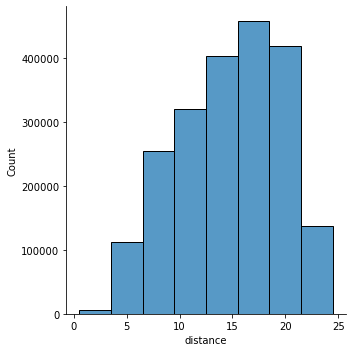

In [20]:
sns.displot(total_edges, x="distance", binwidth=3).savefig(PLOT_PATH+'hist_distances.png')

In [22]:
total_edges['is_border'] = total_edges.apply((lambda x : 1 if ( x.tissue_category_1 != x.tissue_category_2) else  0), axis = 1)

In [24]:
total_edges.head(2)

,distance,cell_id_1,cell_id_2,tissue_category_1,tissue_category_2,phenotype_1,phenotype_2,threshold,is_border
0,13.122881,79853,79902,stroma,stroma,stroma,stroma,18.645,0
1,13.645878,37094,37150,stroma,stroma,stroma,stroma,18.645,0


In [25]:
len(total_edges[total_edges.is_border==1])

28988

## Extracing border cells

### Extracting the cells that are neighbours to the exact border

In [26]:
exact_border_df = total_edges[total_edges.is_border == 1].copy()
### Getting a list of cell_id  that are on the border
border_cells = get_cells_from_edges(exact_border_df)
#### Border dataframe
border_df = pd.DataFrame({})
border_df['cell_id'] = border_cells

In [27]:
### Fixing the radius of the neighberhood
BORDER_RADIUS = 30
### Getting all edges inside the area determined by the radius
border_neighbours = total_edges[total_edges.distance< BORDER_RADIUS].copy()
border_neighbours = border_neighbours.merge(border_df, left_on = 'cell_id_1', right_on='cell_id', how='left')
border_neighbours = border_neighbours.merge(border_df, left_on = 'cell_id_2', right_on='cell_id', how='left')
border_neighbours['is_border'] = border_neighbours.isna().apply(lambda row: not(row.cell_id_x and row.cell_id_y), axis =1)
border_neighbours = border_neighbours.drop(['cell_id_x','cell_id_x'], axis=1)

### Extracting a cell list with all border neighbors

In [28]:
border_neighbours_df = border_neighbours[border_neighbours['is_border']==True]
border_cells_neighbors = get_cells_from_edges(border_neighbours_df)    

### The border column to the edges dataframe

In [29]:
print('The number of cells on the border', len(border_cells))
print('The number of cells in the ', BORDER_RADIUS ,' radius neighberhood',len(border_cells_neighbors))

The number of cells on the border 21884
The number of cells in the  30  radius neighberhood 50510


## Visualising border cells

In [30]:
border_cells_neighbors_df = pd.DataFrame({})
border_cells_neighbors_df['cell_id_1'] = border_cells_neighbors
cell_data_with_border = cell_data[['cell_id','cell_x_position','cell_y_position','tissue_category','phenotype']].copy()
cell_data_with_border = cell_data_with_border.merge(border_cells_neighbors_df, left_on='cell_id', right_on = 'cell_id_1', how='left')
cell_data_with_border['on_border'] = cell_data_with_border.cell_id_1.isna().apply(lambda x: not(x))
cell_data_with_border = cell_data_with_border.drop(['cell_id_1'], axis=1)

In [31]:
cell_data_with_border.head(3)

,cell_id,cell_x_position,cell_y_position,tissue_category,phenotype,on_border
0,1,14040.7,37383.4,stroma,stroma,False
1,2,14049.6,37381.9,stroma,MISSING,False
2,3,14056.5,37381.9,stroma,MISSING,False


subject to tissue type

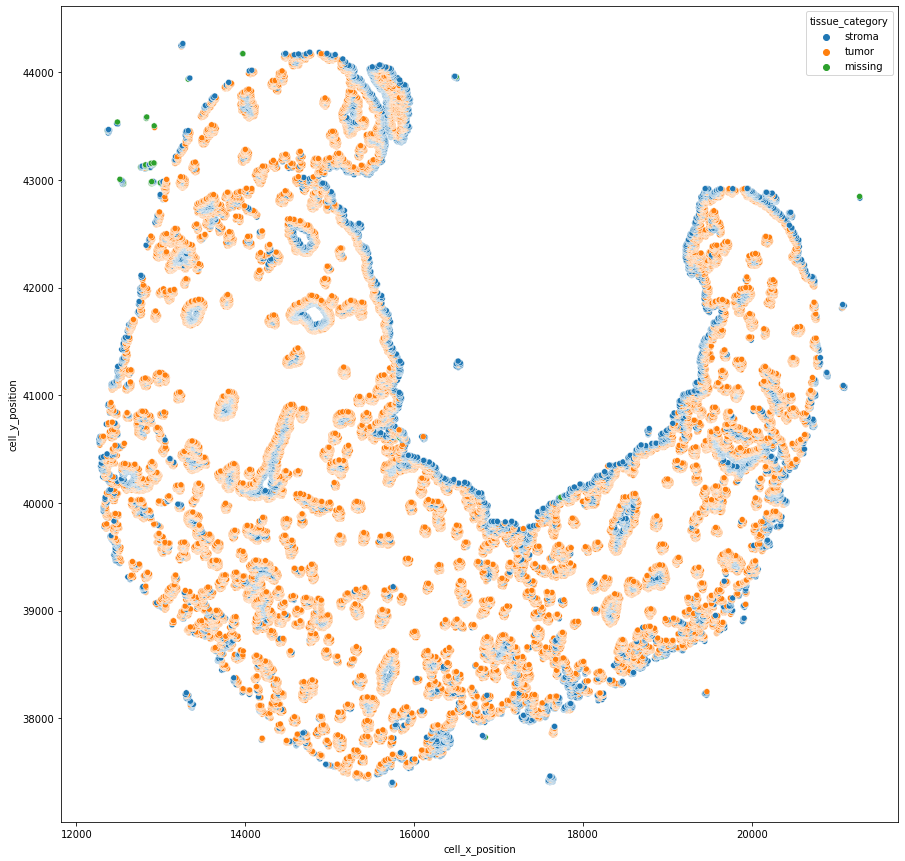

In [32]:
visualise_cells = cell_data_with_border[cell_data_with_border['on_border'] == True]
fig, ax = plt.subplots(figsize = (15,15))
fig = sns.scatterplot(data = visualise_cells , x='cell_x_position', y= 'cell_y_position', hue = 'tissue_category').get_figure()
fig.savefig(PLOT_PATH+'scatterplot_cells_border_tissue.png')

In [35]:
border_cells_neighbors_df = pd.DataFrame({})
border_cells_neighbors_df['cell_id'] = border_cells_neighbors

total_edges = total_edges.merge(border_cells_neighbors_df, left_on = 'cell_id_1', right_on='cell_id', how='left')
total_edges = total_edges.merge(border_cells_neighbors_df, left_on = 'cell_id_2', right_on='cell_id', how='left')

total_edges['is_border'] = total_edges.isna().apply(lambda row: not(row.cell_id_x and row.cell_id_y), axis =1)

total_edges = total_edges.drop(['cell_id_x','cell_id_y'], axis=1)


In [36]:
total_edges.is_border.value_counts()

False    1762626
True      346818
Name: is_border, dtype: int64

subject to phenotype

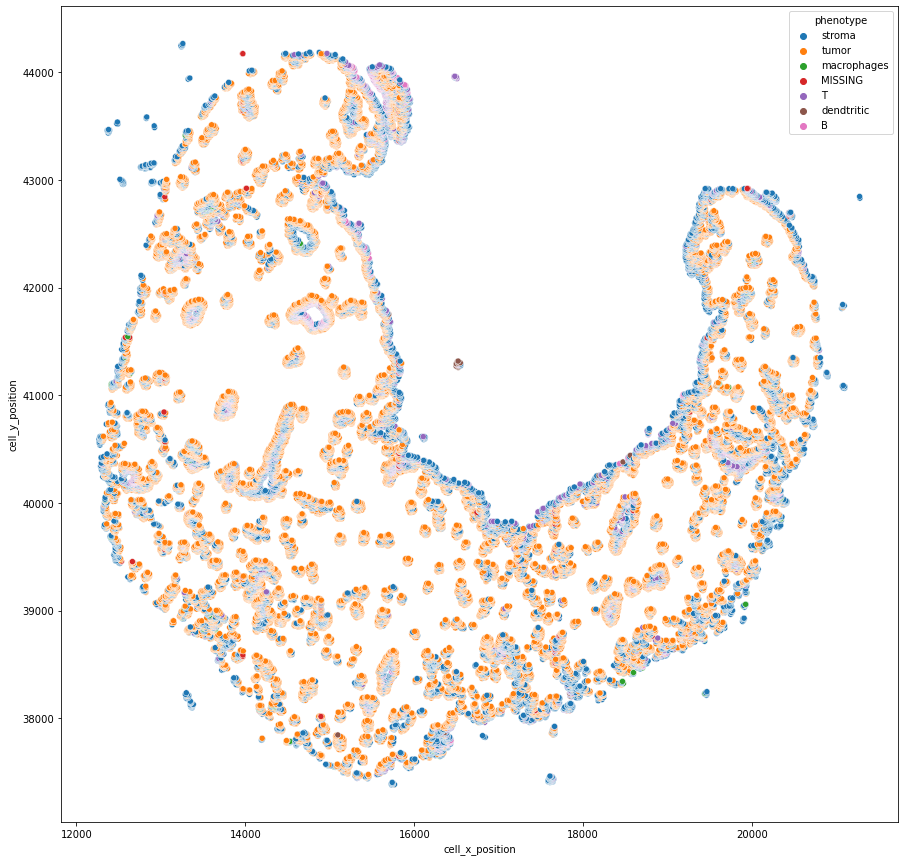

In [37]:
fig, ax = plt.subplots(figsize = (15,15))
sns.scatterplot(data = visualise_cells , x='cell_x_position', y= 'cell_y_position', hue = 'phenotype')
fig.savefig(PLOT_PATH+'scatterplot_cells_border_phenotype.png')

Removing stroma cells 

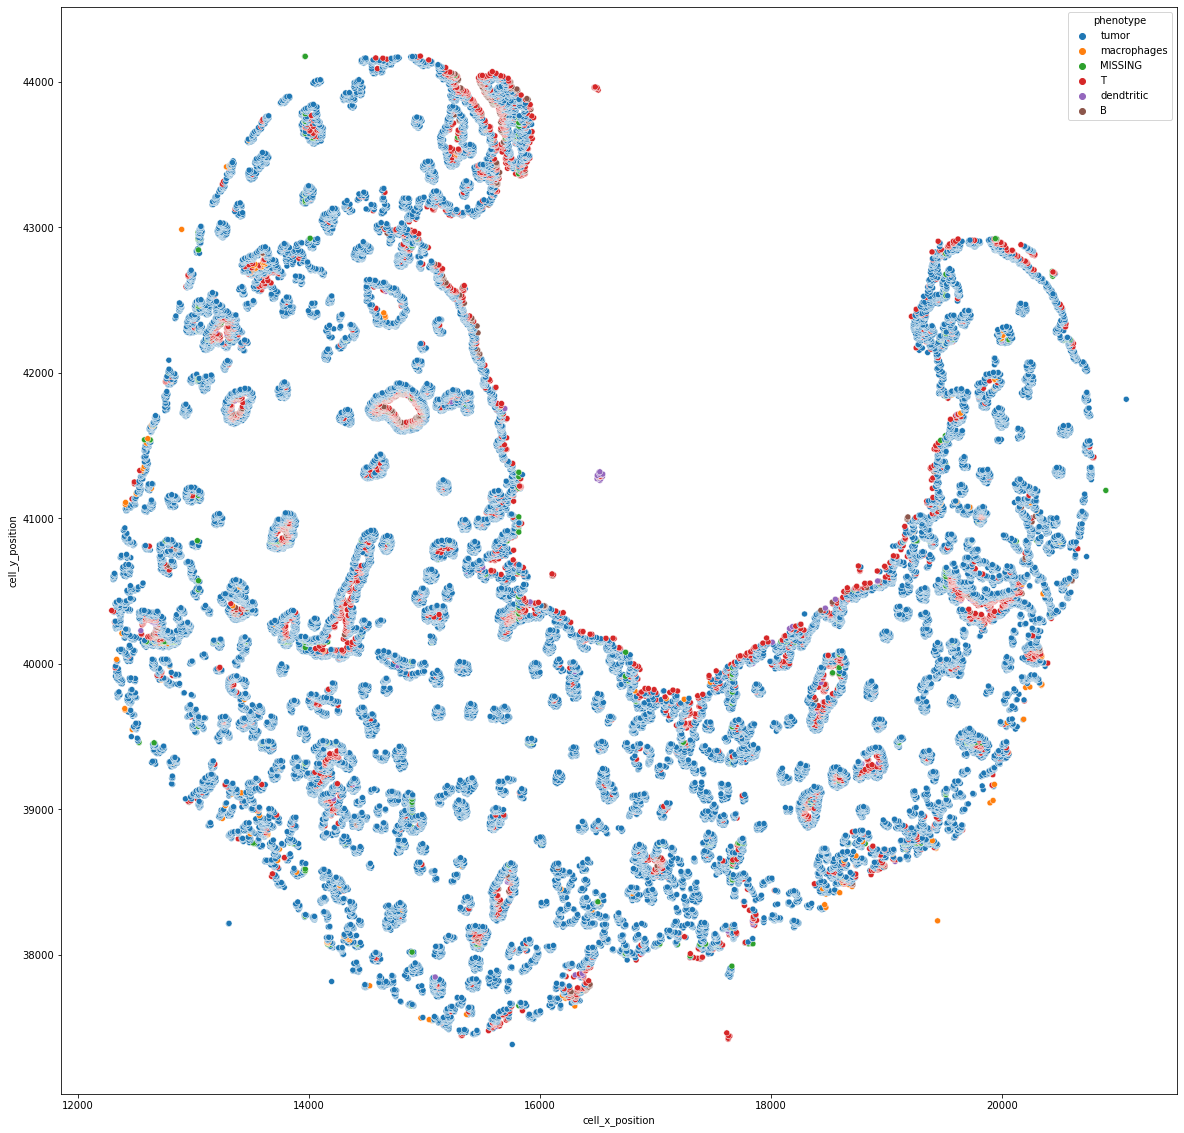

In [38]:
fig, ax = plt.subplots(figsize = (20,20))
visualise_cells = visualise_cells[visualise_cells.phenotype != 'stroma']
sns.scatterplot(data = visualise_cells , x='cell_x_position', y= 'cell_y_position', hue = 'phenotype')
fig.savefig(PLOT_PATH+'scatterplot_cells_border_no_stroma.png')


### Adding neighbour cells to edge data

In [39]:
total_edges.head(2)

,distance,cell_id_1,cell_id_2,tissue_category_1,tissue_category_2,phenotype_1,phenotype_2,threshold,is_border
0,13.122881,79853,79902,stroma,stroma,stroma,stroma,18.645,False
1,13.645878,37094,37150,stroma,stroma,stroma,stroma,18.645,False


## Saving nodes to csv

In [40]:
cell_data_with_border.to_csv(OUTPUT_PATH+'nodes_with_border.csv', index = False)

## Saving edges to csv

In [41]:
total_edges.to_csv(OUTPUT_PATH + 'graph_edges.csv', index = False)

## Neighbourhood on tissue level

In [42]:
degree_table = get_df_degrees(total_edges,cell_data, HIGH_VALUES=False )

stroma
tumor
missing


In [43]:
degree_table.head()

,cell_id,stroma_degree,tumor_degree,missing_degree,total_degree
0,1,10.0,0.0,0.0,10.0
1,2,7.0,0.0,0.0,7.0
2,3,9.0,0.0,0.0,9.0
3,4,1.0,0.0,0.0,1.0
4,5,2.0,0.0,0.0,2.0


## Neighbourhood on Phenotype level


In [44]:
degree_table_1  =  group_and_pivot(total_edges,['cell_id_1','phenotype_2'],'cell_id_2',False).rename(columns={'cell_id_1' : 'cell_id'})
degree_table_2  =  group_and_pivot(total_edges,['cell_id_2','phenotype_1'],'cell_id_1',False).rename(columns={'cell_id_2' : 'cell_id'})
phenotype_table    =  degree_table_1.merge(degree_table_2, on='cell_id', how='outer')
phenotype_table    =  phenotype_table.fillna(0)

phenotypes = cell_data.phenotype.unique()
for phenotype in phenotypes:
    condition = (phenotype in degree_table_1.columns) and (phenotype in degree_table_2.columns)
    if condition :
        
        print(phenotype)
        
        if phenotype in ['stroma','tumor']:
            column_name = phenotype + '_pheno_degree'
        else: 
            column_name = phenotype + '_degree'
            
        phenotype_table[column_name] = phenotype_table.apply(lambda x :   x[phenotype+'_x'] + x[phenotype+'_y'] , axis =1) 
        phenotype_table = phenotype_table.drop([phenotype+'_x',phenotype+'_y'],axis =1)
        
    else :
        
        phenotype_table = phenotype_table.rename(columns = {phenotype : phenotype+'_degree'})

stroma
MISSING
tumor
T
macrophages
dendtritic
B


In [45]:
phenotype_table.head(2)

,cell_id,stroma_pheno_degree,MISSING_degree,tumor_pheno_degree,T_degree,macrophages_degree,dendtritic_degree,B_degree
0,1,8.0,2.0,0.0,0.0,0.0,0.0,0.0
1,2,6.0,1.0,0.0,0.0,0.0,0.0,0.0


In [46]:
#phenotype_grouped = edges_data.groupby(['cell_id_1','phenotype_2']).agg('count')['cell_id_2'].reset_index()

In [47]:
#phenotype_degree_table = pd.pivot_table(phenotype_grouped, values='cell_id_2', index=['cell_id_1'],
#                    columns=['phenotype_2'], aggfunc=np.sum)

#phenotype_degree_table.columns.name = None
#phenotype_degree_table = phenotype_degree_table.fillna(0).reset_index()

## Appending all cell features together

In [48]:
cell_degree_grouped = degree_table.merge(phenotype_table, on = 'cell_id', how = 'left')

In [49]:
cell_degree_grouped.head(3)

,cell_id,stroma_degree,tumor_degree,missing_degree,total_degree,stroma_pheno_degree,MISSING_degree,tumor_pheno_degree,T_degree,macrophages_degree,dendtritic_degree,B_degree
0,1,10.0,0.0,0.0,10.0,8.0,2.0,0.0,0.0,0.0,0.0,0.0
1,2,7.0,0.0,0.0,7.0,6.0,1.0,0.0,0.0,0.0,0.0,0.0
2,3,9.0,0.0,0.0,9.0,8.0,1.0,0.0,0.0,0.0,0.0,0.0


In [50]:
cell_degree_grouped.to_csv(OUTPUT_PATH + 'cell_degree.csv', index = False)

## Counting the occurence of edges

In [56]:
N_EDGES = len(total_edges)

In [51]:
edges_data_filtered = graph_wrangling(total_edges,EDGE_THRSHOLD, only_border = False)

In [52]:
edge_phenotype_count = edges_data_filtered.groupby(['phenotype_1','phenotype_2']).agg('count')[['cell_id_1']]

In [54]:
edge_phenotype_count = edge_phenotype_count.reset_index()

In [57]:
edge_phenotype_count['cell_id_1'] = edge_phenotype_count['cell_id_1']/N_EDGES

In [58]:
edge_phenotype_count.head(3)

,index,phenotype_1,phenotype_2,cell_id_1
0,0,B,B,0.006054
1,1,B,MISSING,0.000194
2,2,B,T,0.006537


In [59]:
edge_phenotype_count_pivotted = pd.pivot_table(edge_phenotype_count, values='cell_id_1', index=['phenotype_1'],
                    columns=['phenotype_2'], aggfunc=np.sum)

edge_phenotype_count_pivotted.columns.name = None

edge_phenotype_count_pivotted = edge_phenotype_count_pivotted.fillna(0)

In [60]:
edge_phenotype_count_pivotted.head(8)

,B,MISSING,T,dendtritic,macrophages,stroma,tumor
phenotype_1,,,,,,,
B,0.006054,0.000194,0.006537,0.000544,0.000006,0.002444,0.000861
MISSING,0.000177,0.000981,0.000481,0.000146,0.000014,0.000835,0.005379
T,0.006577,0.000562,0.023851,0.003259,0.000036,0.011712,0.005295
dendtritic,0.000579,0.000162,0.003471,0.004457,0.000016,0.004193,0.000725
macrophages,0.000001,0.000013,0.000037,0.000017,0.000192,0.000636,0.000233
stroma,0.002439,0.000927,0.012095,0.003910,0.000530,0.043502,0.028179
tumor,0.000883,0.006130,0.005305,0.000662,0.000247,0.029486,0.403513


In [61]:
count_matrix = edge_phenotype_count_pivotted.to_numpy()
diagonal_matrix = np.diag(np.diag(count_matrix))
transpose_matrix = count_matrix.transpose()
total = transpose_matrix + count_matrix - diagonal_matrix

In [62]:
columns = edge_phenotype_count_pivotted.columns
index = edge_phenotype_count_pivotted.index
edge_phenotype_count = pd.DataFrame(data = total, columns = columns, index = index)

In [63]:
edge_phenotype_count

,B,MISSING,T,dendtritic,macrophages,stroma,tumor
phenotype_1,,,,,,,
B,0.006054,0.000371,0.013113,0.001123,0.000007,0.004882,0.001744
MISSING,0.000371,0.000981,0.001043,0.000309,0.000027,0.001763,0.011509
T,0.013113,0.001043,0.023851,0.006730,0.000073,0.023807,0.010600
dendtritic,0.001123,0.000309,0.006730,0.004457,0.000033,0.008102,0.001387
macrophages,0.000007,0.000027,0.000073,0.000033,0.000192,0.001166,0.000480
stroma,0.004882,0.001763,0.023807,0.008102,0.001166,0.043502,0.057665
tumor,0.001744,0.011509,0.010600,0.001387,0.000480,0.057665,0.403513


In [64]:
heatmap_df = edge_phenotype_count

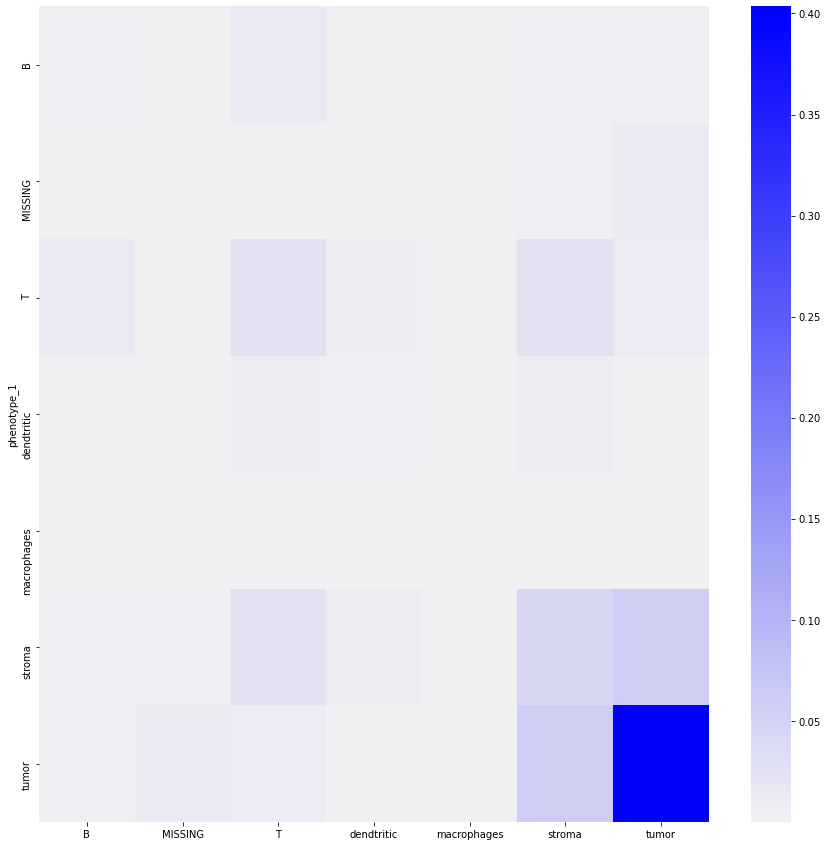

In [65]:
fig, ax = plt.subplots(figsize = (15,15))
sns_fig = sns.heatmap(heatmap_df.iloc[:,:], cmap=sns.color_palette("light:b", as_cmap=True)).get_figure()
sns_fig.savefig(PLOT_PATH+'heatmap.png')

In [66]:
heatmap_df = edge_phenotype_count.drop(['tumor','stroma'], axis =1)

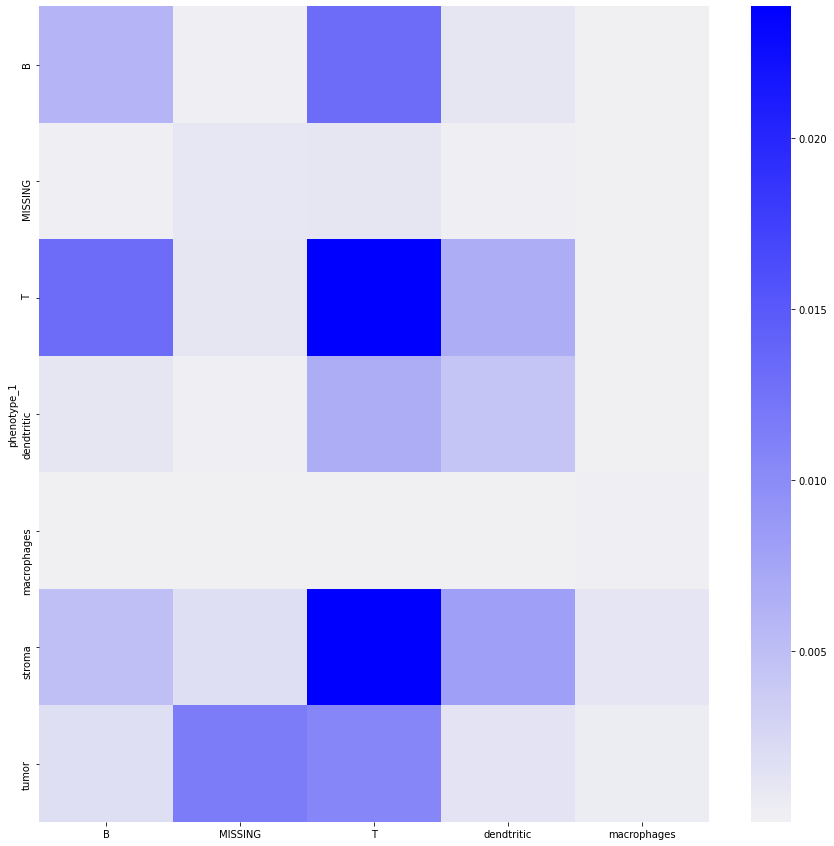

In [67]:
fig, ax = plt.subplots(figsize = (15,15))
sns_fig = sns.heatmap(heatmap_df.iloc[:,:], cmap=sns.color_palette("light:b", as_cmap=True)).get_figure()
sns_fig.savefig(PLOT_PATH+'heatmap_notumor_no_stroma.png')